# Digital Signal Processing Homework (4)

Authors: Brandon, Maxime

Date: May 11, 2024

## Preparation

### Load the files

The organization of files should be like:

```bash
VibrationSignal/
    100.csv
    110.csv
    123.csv
    144.csv
    161.csv
    2365.csv
    2538.csv
    486.csv
functions/
    Skbp.py
main.ipynb
```

In [1]:
# Check the existence of necessary files
if False:
    !cd VibrationSignal && ls -l

### Import

In [2]:
# Check the prerequisite
if False:
    !pip install scienceplots
    !pip install plotly

In [3]:
import pandas as pd
import numpy as np

import scipy.signal

import os

import matplotlib.pyplot as plt

# To generate static figure, use the following code
import scienceplots
plt.style.use(['science'])

# To generate interactive figure, use the following code
import plotly.graph_objects as go

### Parameters settings

In [4]:
fs = 25600 # Sampling Frequency, in Hz
n = 8  # Number of rolling elements
fr = 35  # Shaft speed in Hz
d = 7.92  # Ball diameter in mm
D = 34.55  # Pitch diameter in mm
phi_degrees = 0  # Assumed contact angle

INTERACTIVE = True

### Calculate the fault characteristic frequency

1. **Ballpass Frequency, Outer Race (BPFO)**:
   $$
   \text{BPFO} = \frac{n_{\text{fr}}}{2} \left(1 - \frac{d}{D} \cos \phi \right)
   $$
2. **Ballpass Frequency, Inner Race (BPFI)**:
   $$
   \text{BPFI} = \frac{n_{\text{fr}}}{2} \left(1 + \frac{d}{D} \cos \phi \right)
   $$
3. **Fundamental Train Frequency (FTF)**:
   $$
   \text{FTF} = \frac{f_{\text{r}}}{2} \left(1 - \frac{d}{D} \cos \phi \right)
   $$
4. **Ball (Roller) Spin Frequency (BSF)**:
   $$
   \text{BSF} = \frac{D f_{\text{r}}}{2d} \left(1 - \left(\frac{d}{D} \cos \phi \right)^2 \right)
   $$


In [5]:
class BearingAnalysis:
    def __init__(self, n, fr, d, D, phi_degrees):
        self.n = n
        self.fr = fr
        self.d = d / 1000  # Convert mm to meters
        self.D = D / 1000  # Convert mm to meters
        self.phi = np.radians(phi_degrees)  # Convert degrees to radians

    def calculate_bpfi(self):
        return self.n * self.fr / 2 * (1 + self.d / self.D * np.cos(self.phi))

    def calculate_bpfo(self):
        return self.n * self.fr / 2 * (1 - self.d / self.D * np.cos(self.phi))

    def calculate_ftf(self):
        return self.fr / 2 * (1 - self.d / self.D * np.cos(self.phi))

    def calculate_bsf(self):
        return self.D * self.fr / (2 * self.d) * (1 - (self.d / self.D * np.cos(self.phi))**2)

### Generate the signal class

In [6]:
from scipy.fft import fft, fftfreq

class Signal:
    def __init__(self, file_name, data, fs, n, fr, d, D, phi_degrees):
        self.file_name = file_name
        self.xt_list = np.array(data)
        self.fs = fs
        self.t_list = np.arange(len(self.xt_list)) / fs
        self.f_list, self.xf_list = self.calculate_fft()
        
        # Initialize BearingAnalysis and calculate fault frequencies
        bearing = BearingAnalysis(n, fr, d, D, phi_degrees)
        self.bpfi = bearing.calculate_bpfi()
        self.bpfo = bearing.calculate_bpfo()
        self.ftf = bearing.calculate_ftf()
        self.bsf = bearing.calculate_bsf()
    
    def calculate_fft(self):
        N = len(self.xt_list)
        xf = fft(self.xt_list)
        f = fftfreq(N, 1 / self.fs)
        return f, np.abs(xf)
    
    def plot_time_domain(self):
        plt.figure(figsize=(10, 4))
        plt.plot(self.t_list, self.xt_list, label='Original Signal')
        plt.xlabel('Time (s)')
        plt.ylabel('Signal Amplitude')
        plt.title(f'Time Domain Representation of {self.file_name}')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def plot_frequency_domain(self):
        N = len(self.xt_list)
        half_n = N // 2
        plt.figure(figsize=(10, 4))
        plt.plot(self.f_list[:half_n], self.xf_list[:half_n], label='FFT Spectrum')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.title(f'Frequency Domain Representation of {self.file_name}')
        plt.legend()
        plt.grid(True)
        plt.show()

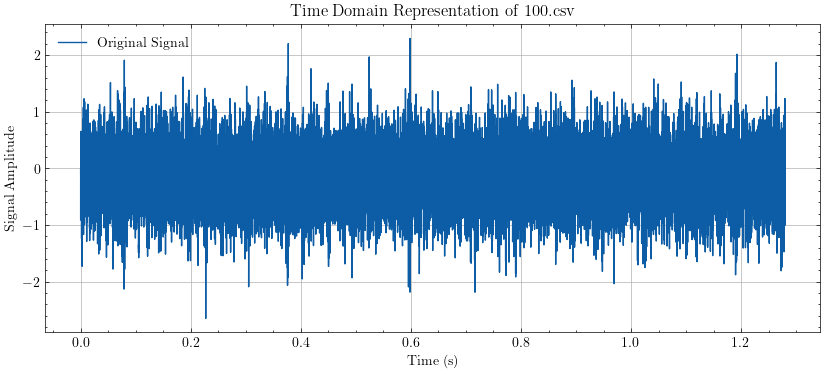

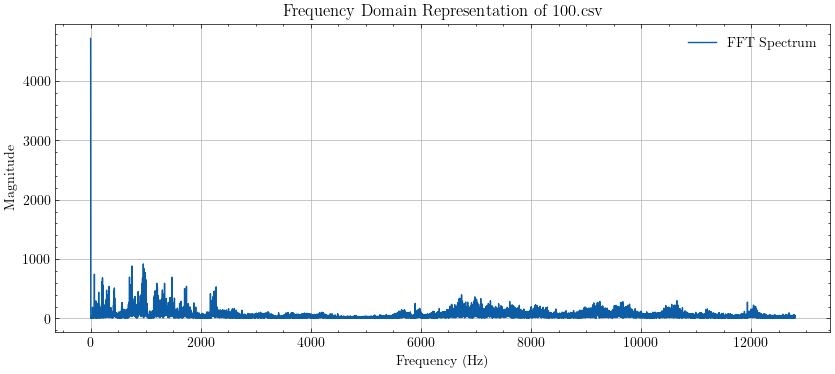

In [7]:
folder_path = './VibrationSignal/'

signals = {}

# Iterate over files in the directory
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        data = df.iloc[:, 0].values  


        if (file_name in ['100.csv', '110.csv', '123.csv', '144.csv']):
            signal = Signal(file_name, data, fs, n, 35, d, D, phi_degrees)
        elif (file_name in ['161.csv', '486.csv']):
            signal = Signal(file_name, data, fs, n, 37.5, d, D, phi_degrees)
        elif (file_name in ['2365.csv', '2538.csv']):
            signal = Signal(file_name, data, fs, n, 40, d, D, phi_degrees)


        signals[file_name] = signal

signals['100.csv'].plot_time_domain()
signals['100.csv'].plot_frequency_domain()

## Envelope spectrum

In [8]:
from scipy.signal import hilbert
import math

array([-0.6596112 ,  0.18966376, -2.86291317, ..., -1.13397985,
       -0.35151102, -2.32360398])

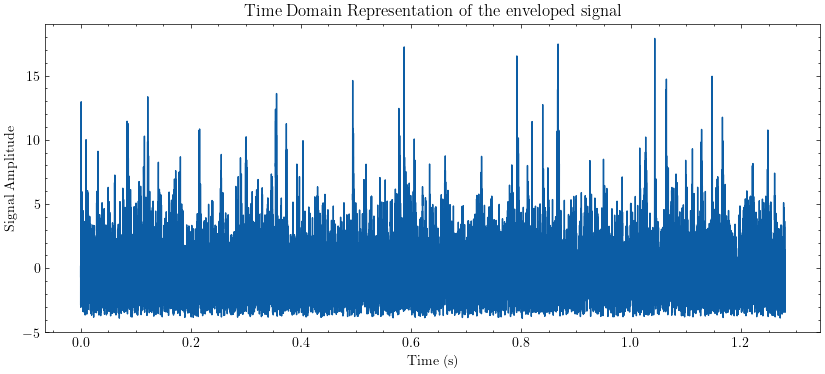

In [9]:
def envelope(t_values, xt_values, plot=False):
    upper_envelope = np.abs(hilbert(xt_values))
    envelope_signal = upper_envelope - np.mean(upper_envelope)

    if plot:
        plt.figure(figsize=(10, 4))
        plt.xlabel('Time (s)')
        plt.ylabel('Signal Amplitude')
        plt.title(f'Time Domain Representation of the enveloped signal')
        plt.plot(t_values, envelope_signal)
    return envelope_signal

# Test
t_list, xt_list = signals['144.csv'].t_list, signals['144.csv'].xt_list
envelope(t_list, xt_list, plot=True)

In [10]:
from scipy.fft import fft, fftfreq

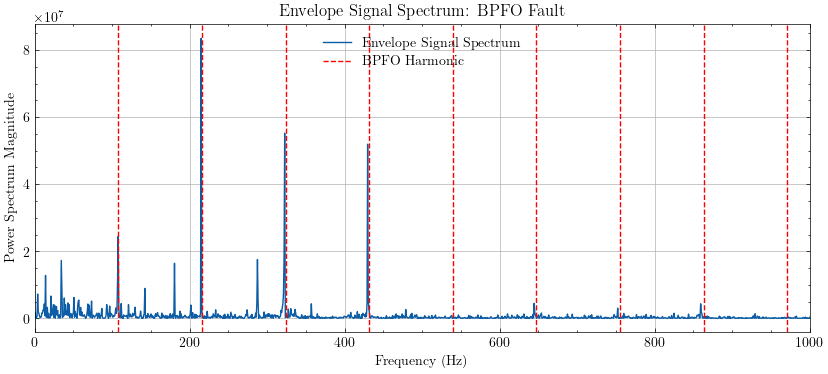

In [11]:
def fault_analysis_basic(signal, fault_freq=None, freq_label=None, num_harmonics=10):
    t_values, xt_values = signal.t_list, signal.xt_list
    envelope_xt_values = envelope(t_values, xt_values)
    fft_values = fft(envelope_xt_values)
    freqs = fftfreq(len(envelope_xt_values), 1/signal.fs)

    positive_indices = freqs > 0
    freqs = freqs[positive_indices]
    fft_values = np.abs(fft_values[positive_indices])
    
    power_spectrum = np.abs(fft_values)**2 
    plt.figure(figsize=(10, 4))
    plt.plot(freqs, power_spectrum, label='Envelope Signal Spectrum')
    plt.xlim([0, 1000])  # Limit frequency to 1000 Hz for better visibility

    if fault_freq:
        for i in range(1, num_harmonics + 1):
            harmonic_freq = i * fault_freq
            if harmonic_freq < 1000:
                plt.axvline(x=harmonic_freq, color='r', linestyle='--', 
                            label=f'{freq_label} Harmonic' if i == 1 else "")
    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectrum Magnitude')
    plt.title(f'Envelope Signal Spectrum: {freq_label} Fault')
    plt.legend()
    plt.grid(True)
    plt.show()

signal = signals['144.csv']  
fault_analysis_basic(signal, signal.bpfo, 'BPFO')

## Kurtogram Analysis

In [12]:
from functions.Skbp import fast_kurtogram 
from scipy.stats import kurtosis
from scipy.signal import butter, lfilter
import mpl_toolkits.axes_grid1

(11750.0, 2133.3333333333335)

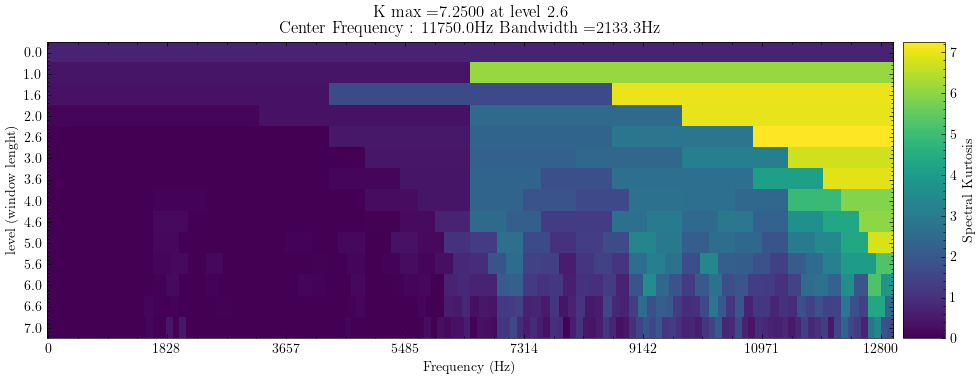

In [13]:
def spectral_kurtosis_analysis(signal_c, plot=False):
    xt_values = signal_c.xt_list
    fs = signal_c.fs
    
    k = kurtosis(xt_values, fisher=False)
    Kwav, Level_w, freq_w, c, max_Kurt, bandwidth, level_max = fast_kurtogram(xt_values, fs, nlevel=7)     # Center frequency & bandwidth obtained from kurtogram
    minw = np.where(Level_w == level_max)[0][0]
    kurtw = np.where(Kwav[minw, :] == max_Kurt)[0][0]
    bandw = freq_w[kurtw]
    central_freq = bandw + bandwidth/2

    if plot:
        plt.figure(figsize=(10, 4))
        ax = plt.gca()
        xlavel = np.array(np.arange(0, fs/2+fs/2/7, fs/2/7), dtype=int)
        im = ax.imshow(Kwav, interpolation='none', aspect='auto')
        plt.xticks(np.arange(0, Kwav.shape[1], Kwav.shape[1] // 7), labels=xlavel)
        plt.title(f'K max ={max_Kurt:.4f} at level {level_max:.1f} '
                f'\nCenter Frequency : {central_freq:.1f}Hz \t Bandwidth ={bandwidth:.1f}Hz')
        plt.xlabel('Frequency (Hz)')
        plt.yticks(np.arange(0, Kwav.shape[0], 1), labels=np.round(Level_w, 1))
        plt.ylabel('level (window lenght)')
        divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        plt.colorbar(im, cax=cax)
        plt.ylabel('Spectral Kurtosis')
        plt.tight_layout()

    return central_freq, bandwidth

spectral_kurtosis_analysis(signals['144.csv'], plot=True)

## Bandpass Filter

(array([0.00000000e+00, 3.90625000e-05, 7.81250000e-05, ...,
        1.27988281e+00, 1.27992188e+00, 1.27996094e+00]),
 array([-0.00096627,  0.00844021, -0.03430376, ...,  0.1996427 ,
        -0.00447661, -0.25151068]))

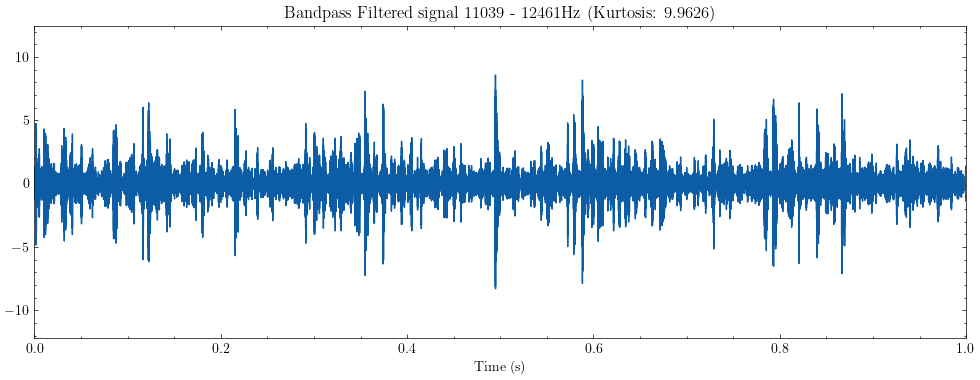

In [14]:
def bandpass(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], 'bandpass')
    y = lfilter(b, a, data, axis=0)
    return y

def kurtosis_and_bpfilter_process(signal_c, plot=False):
    cf, bandwidth = spectral_kurtosis_analysis(signal_c)
    xt_values = signal_c.xt_list
    t_values = signal_c.t_list

    xt_bandpass_values = bandpass(xt_values, cf-bandwidth/3, cf+bandwidth/3, fs, 4)
    k1 = kurtosis(xt_bandpass_values, fisher=False)
    
    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(t_values, xt_bandpass_values); plt.xlim(0,1)
        plt.title(f'Bandpass Filtered signal {cf-bandwidth/3:.0f} - {cf+bandwidth/3:.0f}Hz (Kurtosis: {k1:.4f})')
        plt.xlabel('Time (s)')
        plt.tight_layout()
    
    return t_values, xt_bandpass_values
    
    
kurtosis_and_bpfilter_process(signals['144.csv'], plot=True)

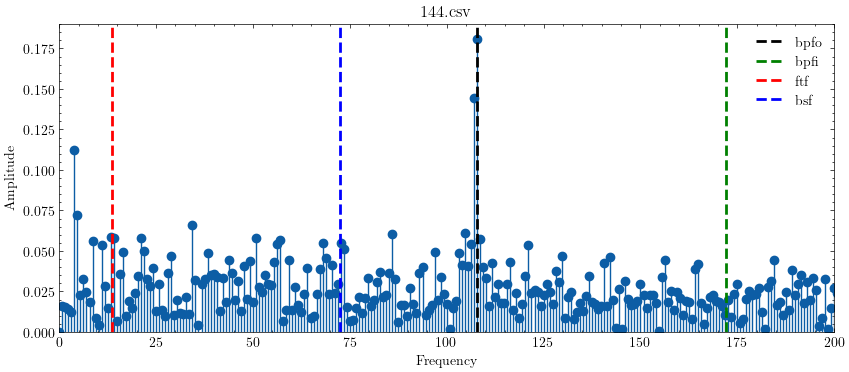

In [15]:
def envelope_analysis(t_values, xt_bandpass_values, bpfo, bpfi, ftf, bsf, title):
    xt_envelope_values = envelope(t_values, xt_bandpass_values)
    N = len(xt_envelope_values)
    Xf = np.abs(fft(xt_envelope_values))/N 
    Xf = Xf[0: math.ceil(N/2)]
    f = np.arange(0,N)/N*fs; f = f[0:math.ceil(N/2)]    
    plt.figure(figsize=(10, 4))
    plt.stem(f, Xf, basefmt=" ")
    plt.xlim(0, 200)
    plt.axvline(bpfo, c='k', ls='--', linewidth=2, label='bpfo')
    plt.axvline(bpfi, c='g', ls='--', linewidth=2, label='bpfi')
    plt.axvline(ftf, c='r', ls='--', linewidth=2, label='ftf')
    plt.axvline(bsf, c='b', ls='--', linewidth=2, label='bsf')
    plt.title(f'{title}')
    plt.ylim(0,)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.legend()
    
# Test
signal = signals['144.csv']
t_values, xt_bandpass_values = kurtosis_and_bpfilter_process(signal)
envelope_analysis(t_values, xt_bandpass_values, signal.bpfo, signal.bpfi, signal.ftf, signal.bsf, signal.file_name)

## Analysis to all the signals

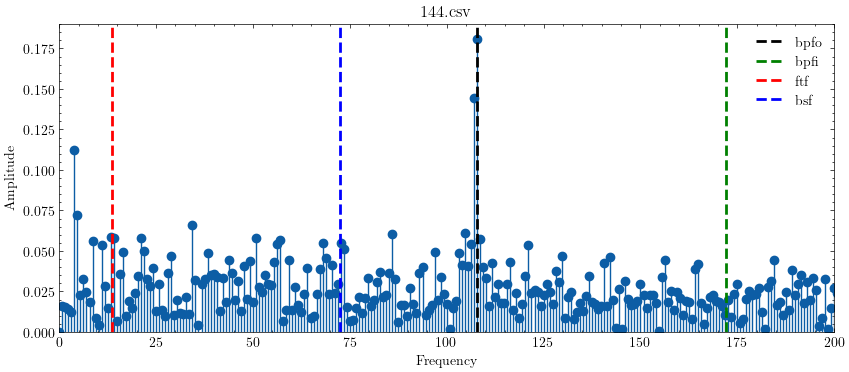

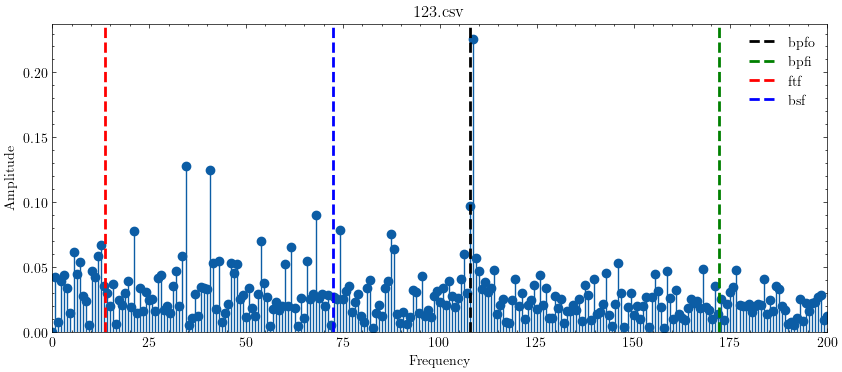

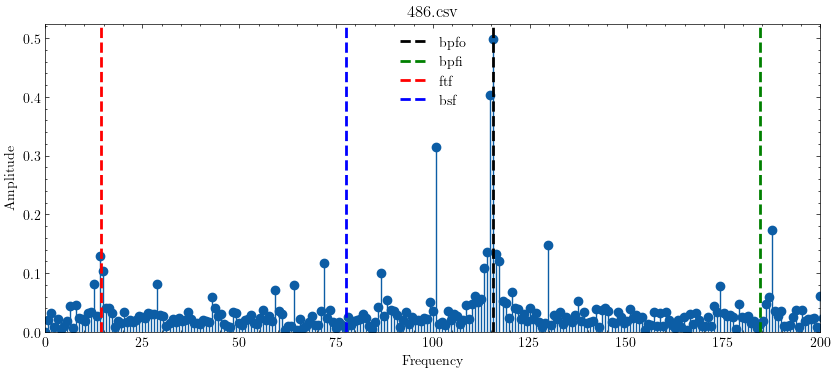

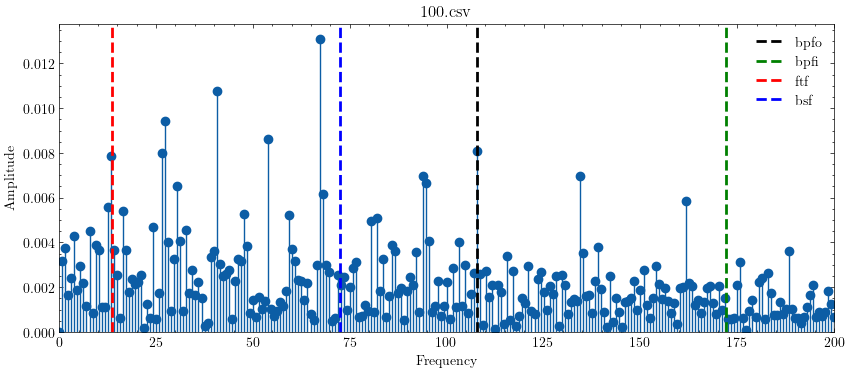

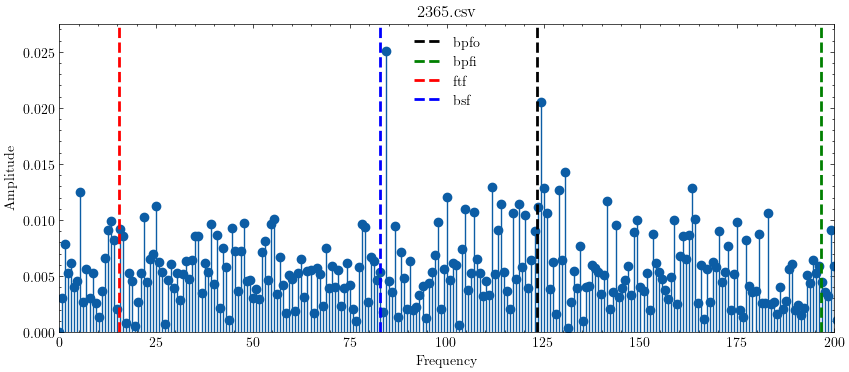

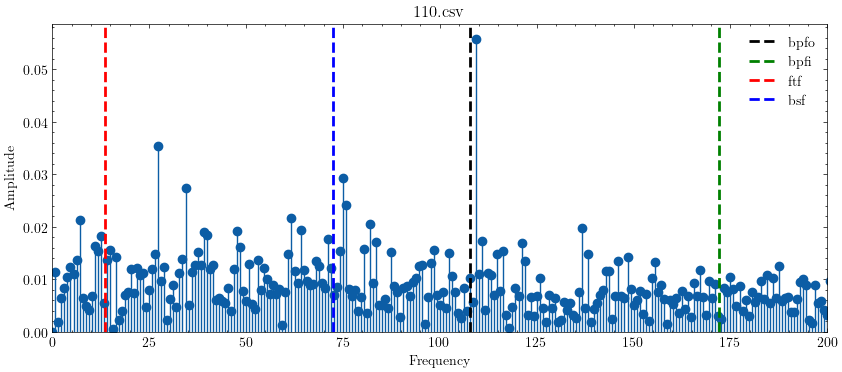

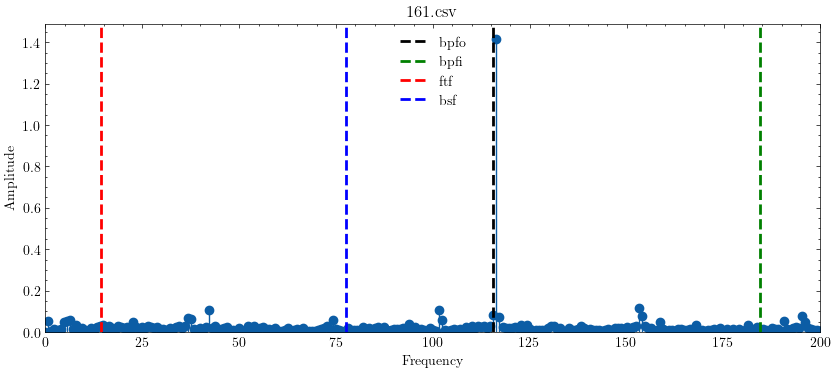

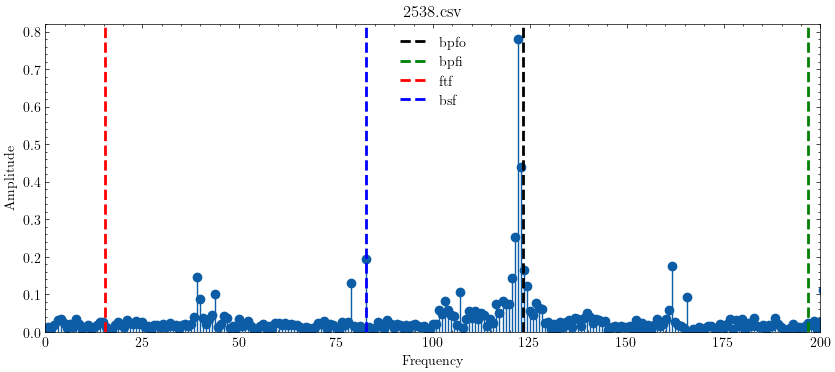

In [16]:
for signal in signals:
    analysis_signal = signals[signal]
    t_values, xt_bandpass_values = kurtosis_and_bpfilter_process(analysis_signal)
    _ = envelope_analysis(t_values, xt_bandpass_values, \
                                    analysis_signal.bpfo, \
                                    analysis_signal.bpfi, \
                                    analysis_signal.ftf, \
                                    analysis_signal.bsf, \
                                    analysis_signal.file_name)